In [13]:
project_name = '06b-anime-dcgan'

In [14]:
!pip install opendatasets --upgrade --quiet

In [15]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [16]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [17]:
import os
import glob
from PIL import Image
from collections import Counter

# Set the directory containing the images
image_dir = './animefacedataset/images'

# Check if the directory exists and contains files
if os.path.isdir(image_dir):
    image_files = glob.glob(os.path.join(image_dir, '*'))
    print(f"Directory: {image_dir}")
    print(f"Contains {len(image_files)} files")

    # Variables to store dataset properties
    resolutions = Counter()
    color_modes = Counter()
    corrupted_files = []

    # Loop through each image file in the directory
    for file in image_files:
        try:
            with Image.open(file) as img:
                # Gather resolution and color mode statistics
                resolutions[img.size] += 1
                color_modes[img.mode] += 1
        except (IOError, OSError):
            # Catch and record any corrupted images that cannot be opened
            corrupted_files.append(file)

    # Print dataset properties
    print("\nDataset Summary:")
    print(f"Total Images: {len(image_files)}")
    print(f"Corrupted Images: {len(corrupted_files)}")
    print("\nResolution Distribution:")
    for resolution, count in resolutions.items():
        print(f"{resolution}: {count} images")
    print("\nColor Mode Distribution:")
    for mode, count in color_modes.items():
        print(f"{mode}: {count} images")

    # Optionally, print paths of corrupted files
    if corrupted_files:
        print("\nCorrupted Files:")
        for file in corrupted_files:
            print(file)

else:
    print(f"Directory {image_dir} does not exist.")


Directory: ./animefacedataset/images
Contains 63565 files

Dataset Summary:
Total Images: 63565
Corrupted Images: 0

Resolution Distribution:
(84, 84): 1245 images
(76, 76): 942 images
(94, 94): 1534 images
(60, 60): 530 images
(102, 102): 1276 images
(89, 89): 1360 images
(92, 92): 1636 images
(70, 70): 646 images
(63, 63): 524 images
(87, 87): 1264 images
(62, 62): 636 images
(117, 117): 393 images
(96, 96): 1556 images
(73, 73): 787 images
(108, 108): 825 images
(80, 80): 923 images
(114, 114): 493 images
(111, 111): 590 images
(72, 72): 765 images
(120, 120): 292 images
(91, 91): 1447 images
(66, 66): 632 images
(104, 104): 1200 images
(75, 75): 778 images
(109, 109): 760 images
(67, 67): 589 images
(95, 95): 1530 images
(81, 81): 1020 images
(68, 68): 638 images
(85, 85): 1272 images
(110, 110): 681 images
(71, 71): 633 images
(97, 97): 1406 images
(105, 105): 1011 images
(88, 88): 1337 images
(82, 82): 1085 images
(98, 98): 1500 images
(93, 93): 1434 images
(77, 77): 869 images
(

In [18]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [19]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [20]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [23]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

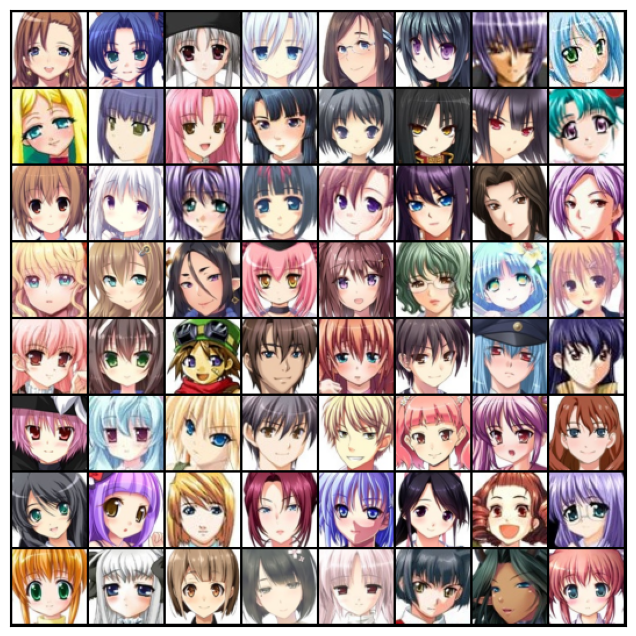

In [24]:
show_batch(train_dl)

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cpu')

In [27]:
train_dl = DeviceDataLoader(train_dl, device)

In [28]:
import torch.nn as nn

In [29]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [30]:

discriminator = to_device(discriminator, device)

In [31]:
latent_size = 128

In [32]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


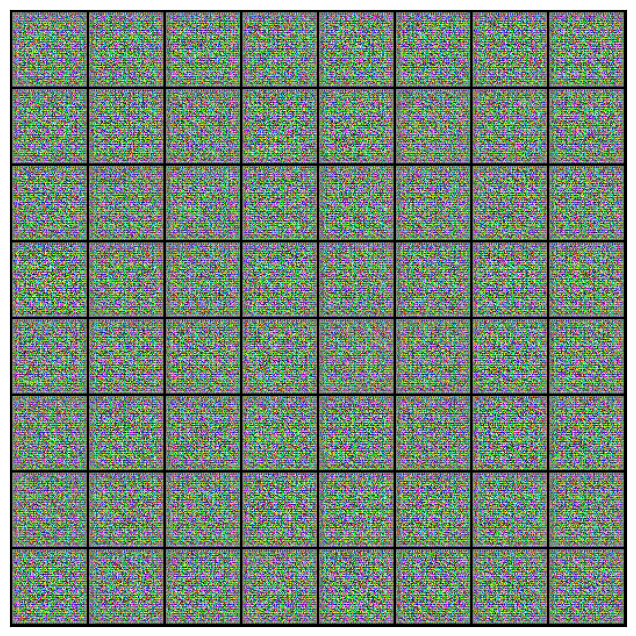

In [33]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [34]:
generator = to_device(generator, device)

In [35]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [36]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [37]:
from torchvision.utils import save_image

In [38]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [39]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [40]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


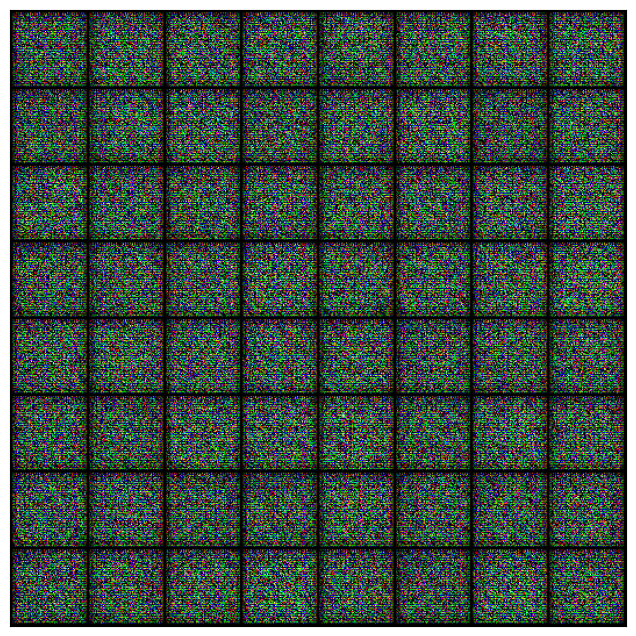

In [41]:
save_samples(0, fixed_latent)

In [42]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [43]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [44]:
lr = 0.0001
epochs = 50

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0020.png')

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
! pip install gradio

In [ ]:
import gradio as gr
import torch
import torch.nn as nn
from torchvision.utils import save_image
import os

# Load the pre-trained generator model
latent_size = 128

# Define the generator architecture (assuming this is already defined in your original code)
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

# Load the model state (set weights_only=True to suppress the warning)
generator.load_state_dict(torch.load('G.pth', weights_only=False))
generator.eval()  # Set the generator to evaluation mode

# Define the function to generate images
def generate_image(num_images=1):
    # Generate random latent tensors
    latent = torch.randn(num_images, latent_size, 1, 1)  # Adjust the shape as needed
    with torch.no_grad():  # Disable gradient calculation for inference
        fake_images = generator(latent)
    # Convert images to the correct format
    images = (fake_images + 1) / 2  # Rescale from [-1, 1] to [0, 1]

    # Save images to a temporary directory and return paths
    os.makedirs('generated', exist_ok=True)
    filepaths = []
    for i in range(num_images):
        filepath = os.path.join('generated', f'anime_face_{i+1}.png')
        save_image(images[i], filepath)
        filepaths.append(filepath)
    return filepaths

# Create Gradio UI
iface = gr.Interface(
    fn=generate_image,
    inputs=gr.Slider(minimum=1, maximum=10, step=1, value=1, label="Number of Images to Generate"),
    outputs=gr.Gallery(label="Generated Anime Faces"),
    title="Anime Face Generator",
    description="Generate anime faces using a trained GAN model.",
)

# Launch the Gradio app
iface.launch()
